In [3]:
%matplotlib inline
import time
import torch
from torch import nn,optim
from torch.utils.data import Dataset,DataLoader
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import sys
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
def show_images(imgs,num_rows,num_cols,scale=2):
    figsize=(num_cols*scale,num_rows*scale)
    _,axes=plt.subplots(num_rows,num_cols,figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i*num_cols+j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes
def apply(img,aug,num_rows=2,num_cols=4,scale=1.5):
    Y=[aug(img) for _ in range(num_cols*num_rows)]
    show_images(Y,num_rows,num_cols,scale)

Files already downloaded and verified


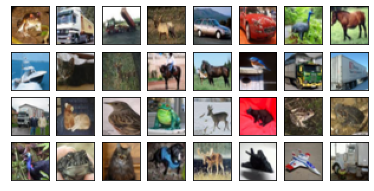

In [7]:
all_imges=torchvision.datasets.CIFAR10(train=True,root='./Datasets/CIFAR',download=True)
show_images([all_imges[i][0] for i in range(32)],4,8,scale=0.8);

In [8]:
flip_aug=torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(),torchvision.transforms.ToTensor()])
no_aug=torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

In [9]:
num_workers=0 if sys.platform.startswith('win32') else 4
def load_cifar10(is_train,augs,batch_size,root='./Datasets/CIFAR'):
    dataset=torchvision.datasets.CIFAR10(root=root,train=is_train,transform=augs,download=True)
    return DataLoader(dataset,batch_size=batch_size,shuffle=is_train,num_workers=num_workers)

# 使用图像增广训练模型

In [10]:
def evaluate_accuracy(data_iter,net,device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    acc_sum,n=0.0,0
    with torch.no_grad():
        for X,y in data_iter:
            if isinstance(net,torch.nn.Module):
                net.eval()#评估模式，这会关闭dropout
                acc_sum+=(net(X.to(device)).argmax(dim=1)==y.to(device)).float().sum().cpu().item()
                net.train()#改回训练模式
            else:
                if('is_training' in net.__code__.co_varname):
                    acc_sum+=(net(X,is_training=False).argmax(dim=1)==y).float().sum().item()
            n+=y.shape[0]
    return acc_sum/n

In [11]:
def train(train_iter,test_iter,net,loss,optimizer,device,num_epochs):
    net=net.to(device)
    print('training on',device)
    batch_count=0
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n,start=0.0,0.0,0,time.time()
        for X,y in train_iter:
            X=X.to(device)
            y=y.to(device)
            y_hat=net(X)
            l=loss(y_hat,y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.cpu().item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().cpu().item()
            n+=y.shape[0]
            batch_count+=1
        test_acc=evaluate_accuracy(test_iter,net)
        print('epoch %d,loss %.4f,train acc %.3f,test acc %.3f,time %.1f sec'%(epoch+1,train_l_sum/batch_count,train_acc_sum/n,test_acc,time.time()-start))
        

In [12]:
import time
import torch
from torch import nn,optim
import torch.nn.functional as F
import sys
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Residual(nn.Module):
    def __init__(self,in_channels,out_channels,use_1x1conv=False,stride=1):
        super(Residual,self).__init__()
        self.conv1=nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,stride=stride)
        self.conv2=nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1)
        if use_1x1conv:
            self.conv3=nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride)
        else:
            self.conv3=None
        self.b1=nn.BatchNorm2d(out_channels)
        self.b2=nn.BatchNorm2d(out_channels)
    def forward(self,x):
        Y=F.relu(self.b1(self.conv1(x)))
        Y=self.b2(self.conv2(Y))
        if self.conv3:
            x=self.conv3(x)
        return F.relu(Y+x)
    

In [13]:
net=nn.Sequential(
    nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
)

In [14]:
def resnet_block(in_channels,out_channels,num_residuals,first_block=False):
    if first_block:
        assert in_channels==out_channels # 第⼀个模块的通道数同输⼊通道数⼀致
    blk=[]
    for i in range(num_residuals):
        if i==0 and not first_block:
            blk.append(Residual(in_channels,out_channels,use_1x1conv=True,stride=2))
        else:
            blk.append(Residual(out_channels,out_channels))
    return nn.Sequential(*blk)

In [15]:
net.add_module('resnet_block1',resnet_block(64,64,2,first_block=True))
net.add_module('resnet_block2',resnet_block(64,128,2))
net.add_module('resnet_block3',resnet_block(128,256,2))
net.add_module('resnet_block4',resnet_block(256,512,2))

In [16]:
class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        super(GlobalAvgPool2d,self).__init__()
    def forward(self,x):
        return F.avg_pool2d(x,kernel_size=x.size()[2:])

In [17]:
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer,self).__init__()
    def forward(self,x):
        return x.view(x.shape[0],-1)

In [18]:
net.add_module('global_avg_pool',GlobalAvgPool2d()) #GlobalAvgPool2d的输出: (Batch, 512, 1, 1)
net.add_module('fc',nn.Sequential(FlattenLayer(),nn.Linear(512,10)))

In [21]:
def train_with_data_aug(train_augs,test_augs,lr=0.001):
    batch_size=256
    optimizer=torch.optim.Adam(net.parameters(),lr=lr)
    loss=torch.nn.CrossEntropyLoss()
    train_iter=load_cifar10(True,train_augs,batch_size)
    test_iter=load_cifar10(False,test_augs,batch_size)
    train(train_iter,test_iter,net,loss,optimizer,device,num_epochs=10)

In [22]:
train_with_data_aug(flip_aug,no_aug)

Files already downloaded and verified
Files already downloaded and verified
training on cuda


RuntimeError: Given groups=1, weight of size [64, 1, 7, 7], expected input[256, 3, 32, 32] to have 1 channels, but got 3 channels instead